# SECTION 21, Topological sorting calculations

In [19]:
from matplotlib import pyplot as plt
plt.style.use('default')

from functools import reduce
from collections import defaultdict
import numpy as np
import random

In [20]:
# Simple experiments
simple_graph = {
    'a': ['a', 2],
    'b': ['b', 4]
}

a = list(simple_graph.keys())
b = reduce(lambda a, b: a+b, list(simple_graph.values()))

print(list(set(b) - set(a)))

[2, 4]


In [21]:
class Node:
    def __init__(self, inputs=[], name='None', is_trainable=False):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict() # Store Loss's partial derivation of a value
        self.is_trainable = is_trainable
        
        for node in self.inputs:
            node.outputs.append(self)
        
    def forward(self):
        pass

    def backward(self):
        pass
    
    def __repr__(self):
        return self.name

In [22]:
class Placeholder(Node):
    def __init__(self, name=None, is_trainable=False):
        Node.__init__(self, name=name, is_trainable=is_trainable)
        
    def forward(self, value=None):
        if value is not None: self.value = value

    def backward(self):
        self.gradients[self] = self.outputs[0].gradients[self]
    
class Linear(Node):
    def __init__(self, x, k, b, name=None):
        Node.__init__(self, inputs = [x, k, b], name=name)
        
    def forward(self):
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value

    def backward(self):
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.gradients[self.inputs[0]] = self.outputs[0].gradients[self] * k.value
        self.gradients[self.inputs[1]] = self.outputs[0].gradients[self] * x.value
        self.gradients[self.inputs[2]] = self.outputs[0].gradients[self] * 1
        
class Sigmoid(Node):
    def __init__(self, x, name=None):
        Node.__init__(self, inputs = [x], name=name)
        self.x = self.inputs[0]
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x.value)

    def backward(self):
        self.value = self._sigmoid(self.x.value)
        self.gradients[self.inputs[0]] = self.outputs[0].gradients[self] * self.value * (1 - self.value)

class Loss(Node):
    def __init__(self, y, yhat, name=None):
        Node.__init__(self, inputs = [y, yhat], name=name)
        self.y = self.inputs[0]
        self.y_hat = self.inputs[1]
        
    def forward(self):        
        y_v = np.array(self.y.value)
        yhat_v = np.array(self.y_hat.value)
        self.value = np.mean((y_v - yhat_v) ** 2)
        
    def backward(self):
        y_v = self.y.value
        yhat_v = self.y_hat.value
        self.gradients[self.inputs[0]] = 2*np.mean(y_v - yhat_v)
        self.gradients[self.inputs[1]] = -2*np.mean(y_v - yhat_v)

In [23]:
node_x = Placeholder(name='x')
node_y = Placeholder(name='y')
node_k = Placeholder(name='k', is_trainable=True)
node_b = Placeholder(name='b', is_trainable=True)
node_linear = Linear(x = node_x, k = node_k, b = node_b, name='Linear')
node_sigmoid = Sigmoid(x = node_linear, name='Sigmoid')
node_loss = Loss(y= node_y, yhat = node_sigmoid, name='Loss')

In [24]:
def topologic(graph):
    sorted_node = []

    while graph:
        all_inputs = set(reduce(lambda a, b: a+b, list(graph.values())))
        all_outputs = set(list(graph.keys()))

        need_remove = all_outputs - all_inputs

        if need_remove:
            node = random.choice(list(need_remove))
            sorted_node.append(node)

            if len(graph) == 1: sorted_node += graph[node]
            graph.pop(node)

            for _, links in graph.items():
                if node in links: links.remove(node)
        else:
            raise TypeError('This graph has circle, which cannot get topological order.')

    return sorted_node

In [25]:
feed_dict = {
    node_x: 3,
    node_y: random.random(),
    node_k: random.random(),
    node_b: 0.38,
}

In [26]:
def convert_feed_dict_to_graph(feed_dict):
    need_expend = [n for n in feed_dict]
    
    computing_graph = defaultdict(list)
    
    while need_expend:
        n = need_expend.pop(0) 
        
        if isinstance(n, Placeholder):
            n.value = feed_dict[n]
        
        if n in computing_graph: continue

        for m in n.outputs:
            computing_graph[n].append(m)
            need_expend.append(m)
    
    return computing_graph

In [27]:
sorted_nodes = topologic(convert_feed_dict_to_graph(feed_dict))

In [28]:
sorted_nodes

[b, x, k, Linear, y, Sigmoid, Loss]

### Simulating the computational process of a neural network

In [29]:
def forward(graph_sorted_nodes):
    # Forward
    for node in sorted_nodes:
        node.forward()

def backward(graph_sorted_nodes):
    # Backward
    for node in sorted_nodes[::-1]:
        # if isinstance(node, Loss):
        #     print('loss value: {}'.format(node.value))
        node.backward()

def run_one_epoch(graph_sorted_nodes):
    forward(graph_sorted_nodes)
    backward(graph_sorted_nodes)


def optimize(graph_sorted_nodes, learning_rate=1e-3):
    # optimize
    for node in sorted_nodes:
        if node.is_trainable:
            node.value = node.value + -1 * node.gradients[node] * learning_rate
            # cmp = 'large' if node.gradients[node] > 0 else 'small'
            # print('The value {} of {} needs to be updated. {}'.format(node.name, cmp, node.value))


In [30]:
# Complete once-valued-derivative-update:
loss_history = []
for _ in range(100):
    run_one_epoch(sorted_nodes)
    _loss_node = sorted_nodes[-1]
    assert isinstance(_loss_node, Loss)
    loss_history.append(_loss_node.value)
    optimize(sorted_nodes, learning_rate=1e-1)

In [31]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [32]:
sigmoid_x = sorted_nodes[0].value * sorted_nodes[2].value + sorted_nodes[3].value

sigmoid(sigmoid_x)

0.9322202559578038

In [33]:
sorted_nodes[1].value

3

In [34]:
sorted_nodes

[b, x, k, Linear, y, Sigmoid, Loss]

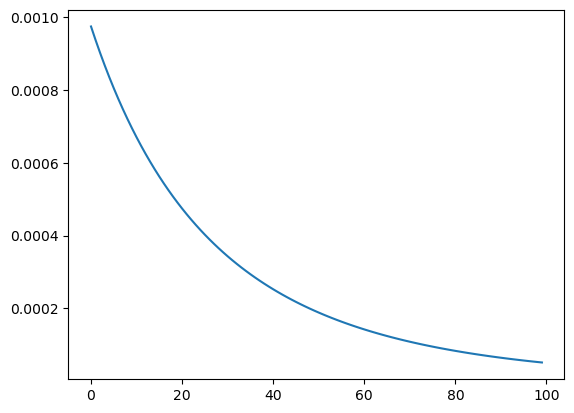

In [35]:
plt.plot(loss_history)